#### Copyright 2019 The TensorFlow Authors.

In [144]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

In [145]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler




import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_classif
import numpy as np
from scipy import stats as st
from sklearn.preprocessing import PowerTransformer

In [146]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
pd.set_option('display.max_columns', None)

## Data processing and exploration

In [147]:
df = pd.read_excel(r"data/trainDataset.xls")
df.head(5)

,ID,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,LNStatus,TumourStage,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,TRG002174,1,144.0,41.0,0,0,0,1,3,3,1,1,2,0.813912,0.724080,23.781937,32.844370,37.696154,38.626416,34.713110,39.572718,14209.458330,26.732440,0.771675,3676.500012,0.258736,14263,-0.163500,0.708860,2897.68930,0.738088,0.406537,4.594629,2.114799,0.278008,0.248168,0.217628,-1.251833,3.366632,0.174026,0.450734,0.386237,2897.68930,0.670

In [148]:
df = df.replace({999:None}).dropna(axis=0, how='any')

In [149]:
X = df.drop(columns=['ID','pCR (outcome)','RelapseFreeSurvival (outcome)'])
y = df['pCR (outcome)']

### Transform Numerical data to normal distribution

In [150]:
float_cols = list(X.select_dtypes(include='float64').columns)
cat_cols = list(X.select_dtypes(include='object').columns)
cat_cols.remove('original_shape_VoxelVolume')
float_cols.append('original_shape_VoxelVolume')
df_floats = df[float_cols]
df_cats = df[cat_cols]

In [151]:
def find_boundaries(df, variable, distance=1.5):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * 1.5)
    upper_boundary = df[variable].quantile(0.75) + (IQR * 1.5)
    return lower_boundary, upper_boundary

def treat_outliers(df, variable, distance=1.5, inplace=True):
    """ 
    Fill outliers with mean
    
    upper_boundary = 75th qualtile + (IQR * diatance)
    upper_boundary = 25th qualtile - (IQR * diatance)
        
    """
    
    lower_boundary, upper_boundary = find_boundaries(df,variable)
    if inplace:
        df[variable] = np.where(df[variable]>upper_boundary,df[variable].mean(),
                                np.where(df[variable]<lower_boundary,df[variable].mean(),df[variable])
                           )
    else:
        return np.where(df[variable]>upper_boundary,df[variable].mean(),
                                np.where(df[variable]<lower_boundary,df[variable].mean(),df[variable])
                           )

In [152]:
for col in float_cols:
    treat_outliers(df_floats, col, inplace=True)

<ipython-input-151-f39ae6f99fe5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variable] = np.where(df[variable]>upper_boundary,df[variable].mean(),
<ipython-input-151-f39ae6f99fe5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variable] = np.where(df[variable]>upper_boundary,df[variable].mean(),
<ipython-input-151-f39ae6f99fe5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

<ipython-input-151-f39ae6f99fe5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variable] = np.where(df[variable]>upper_boundary,df[variable].mean(),
<ipython-input-151-f39ae6f99fe5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variable] = np.where(df[variable]>upper_boundary,df[variable].mean(),
<ipython-input-151-f39ae6f99fe5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

<ipython-input-151-f39ae6f99fe5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variable] = np.where(df[variable]>upper_boundary,df[variable].mean(),
<ipython-input-151-f39ae6f99fe5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variable] = np.where(df[variable]>upper_boundary,df[variable].mean(),
<ipython-input-151-f39ae6f99fe5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

### Normalization

In [153]:
transformer = PowerTransformer(method='yeo-johnson')
df_floats = pd.DataFrame(transformer.fit_transform(df_floats),columns=float_cols)

C:\Users\chaitanyamanem\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [154]:
X = pd.concat([df_cats.reset_index(drop=True),df_floats.reset_index(drop=True)],axis=1)

In [155]:
df_floats.head()

,Age,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,original_shape_VoxelVolume
0,-0.999294,0.529871,1.020400,0.314719,-0.426412,-0.250242,-0.008151,-0.387567,-0.443355,0.240235,-0.103468,1.059139,-0.156213,-1.237161,-1.096726,0.242643,-1.828202,1.681809,-2.374597,0.355517,-2.227895,-2.522101,0.225987,0.174434,-0.435858,-1.562310,-2.451265,0.281263,1.595937,-1.828202,-1.793115,-2.248988,-0.950750,1.677288,-1.781611,0.508571,0.250339,0.867319,0.250339,2.066443,2.049920,-0.244870,-0.244870,-0.245594,-0.245275,-0.473642,1.380599,0.250339,-1.065418

### Splitting the data

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)

### Scaling the data

In [157]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

In [160]:
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [161]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]




In [162]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    """
    if metric == 'loss':
      #plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    """

    plt.legend()

In [163]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [166]:
def experiment(model, EPOCHS = 100, PATIENCE=10, lr = 1e-3 ):
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=PATIENCE,
    mode='max',
    restore_best_weights=True)
    
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=METRICS
        )
    baseline_history = model.fit( X_train, y_train, epochs=EPOCHS,callbacks=[early_stopping],
                                 validation_data=(X_test, y_test), verbose=0
                                )
    plot_metrics(baseline_history)
    
    test_predictions_baseline = model.predict(X_test)
    
    baseline_results = model.evaluate(X_test, y_test, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
        print(name, ': ', value)
        print()
        
    plot_cm(y_test, test_predictions_baseline)
    

In [171]:
def experimentSD(model, EPOCHS = 100, PATIENCE=10, lr = 1e-3 ):
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=PATIENCE,
    mode='max',
    restore_best_weights=True)
    
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=METRICS
        )
    baseline_history = model.fit( X_res, y_res, epochs=EPOCHS,callbacks=[early_stopping],
                                 validation_data=(X_test, y_test), verbose=0
                                )
    plot_metrics(baseline_history)
    
    test_predictions_baseline = model.predict(X_test)
    
    baseline_results = model.evaluate(X_test, y_test, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
        print(name, ': ', value)
        print()
        
    plot_cm(y_test, test_predictions_baseline)
    

### Experiment 1

Restoring model weights from the end of the best epoch: 14.
Epoch 34: early stopping
4/4 [==============================] - 0s 5ms/step
loss :  0.5007956624031067

tp :  2.0

fp :  1.0

tn :  73.0

fn :  22.0

accuracy :  0.7653061151504517

precision :  0.6666666865348816

recall :  0.0833333358168602

auc :  0.7283220887184143

prc :  0.4088897407054901

Legitimate Transactions Detected (True Negatives):  73
Legitimate Transactions Incorrectly Detected (False Positives):  1
Fraudulent Transactions Missed (False Negatives):  22
Fraudulent Transactions Detected (True Positives):  2
Total Fraudulent Transactions:  24


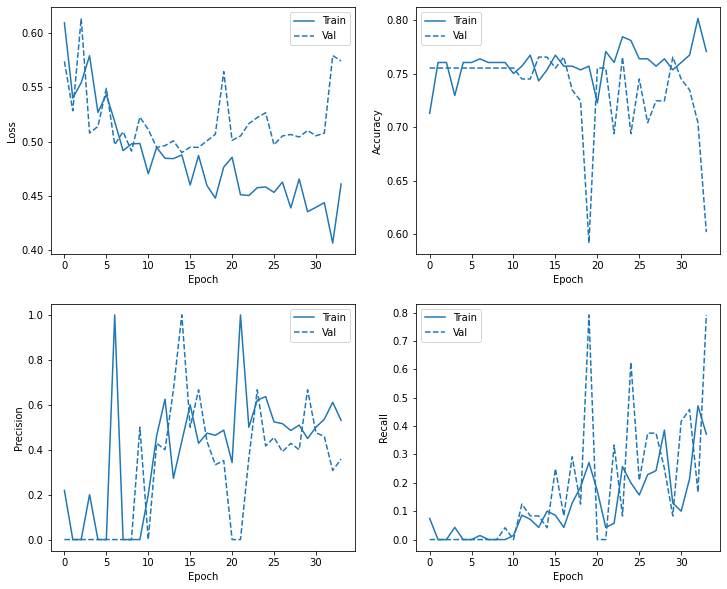

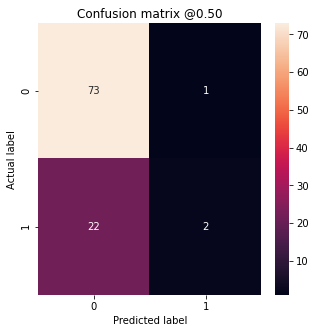

In [323]:
model = keras.Sequential([
      keras.layers.Dense(500, activation='relu',input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(800, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(900, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(500, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(200, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')
  ])

experiment(model, PATIENCE=20)

### Experiment 2

Restoring model weights from the end of the best epoch: 12.
Epoch 112: early stopping
4/4 [==============================] - 0s 6ms/step
loss :  0.5328895449638367

tp :  8.0

fp :  4.0

tn :  70.0

fn :  16.0

accuracy :  0.795918345451355

precision :  0.6666666865348816

recall :  0.3333333432674408

auc :  0.7370495200157166

prc :  0.5371410846710205

Legitimate Transactions Detected (True Negatives):  70
Legitimate Transactions Incorrectly Detected (False Positives):  4
Fraudulent Transactions Missed (False Negatives):  16
Fraudulent Transactions Detected (True Positives):  8
Total Fraudulent Transactions:  24


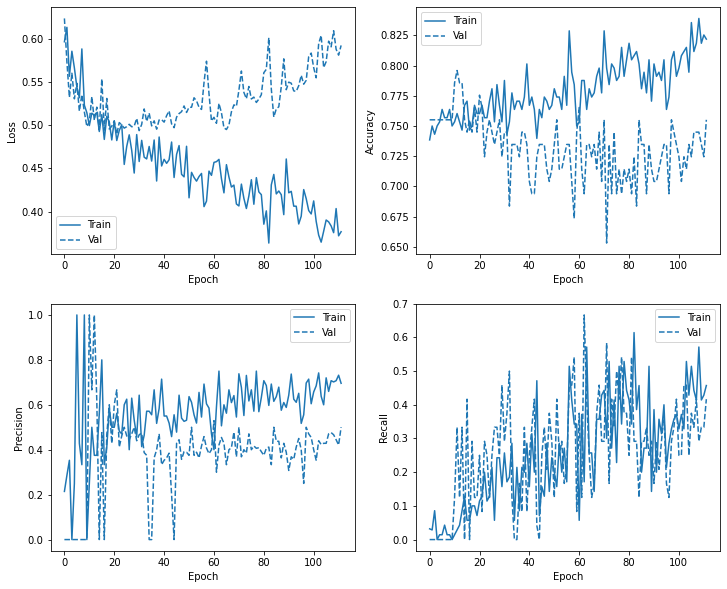

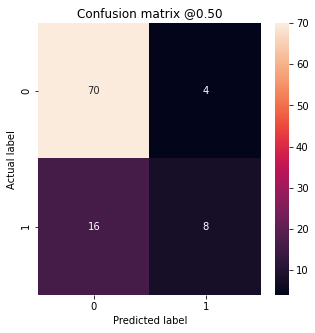

In [324]:
model = keras.Sequential([
      keras.layers.Dense(500, activation='relu',input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.6),
      keras.layers.Dense(800, activation='relu'),
      keras.layers.Dropout(0.6),
      keras.layers.Dense(900, activation='relu'),
      keras.layers.Dropout(0.6),
      keras.layers.Dense(500, activation='relu'),
      keras.layers.Dropout(0.6),
      keras.layers.Dense(200, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')
  ])

experiment(model,EPOCHS = 300, PATIENCE=100, lr = 1e-4)

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

In [260]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(500, activation='relu',input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.4),
      keras.layers.Dense(800, activation='relu'),
      keras.layers.Dropout(0.4),
      keras.layers.Dense(900, activation='relu'),
      keras.layers.Dropout(0.4),
      keras.layers.Dense(500, activation='relu'),
      keras.layers.Dropout(0.4),
      keras.layers.Dense(200, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-4),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### Experiment 3

Restoring model weights from the end of the best epoch: 104.
Epoch 204: early stopping
4/4 [==============================] - 0s 6ms/step
loss :  0.5929314494132996

tp :  11.0

fp :  9.0

tn :  65.0

fn :  13.0

accuracy :  0.7755101919174194

precision :  0.550000011920929

recall :  0.4583333432674408

auc :  0.7314189672470093

prc :  0.41672614216804504

Legitimate Transactions Detected (True Negatives):  65
Legitimate Transactions Incorrectly Detected (False Positives):  9
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  11
Total Fraudulent Transactions:  24


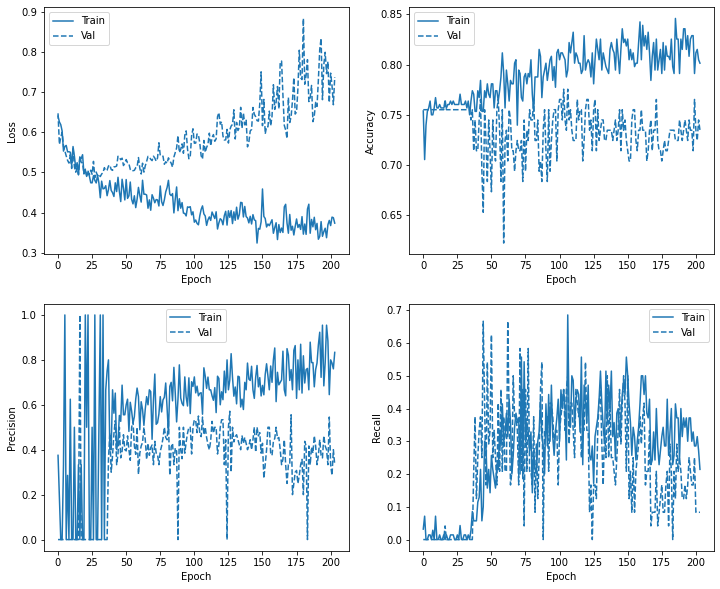

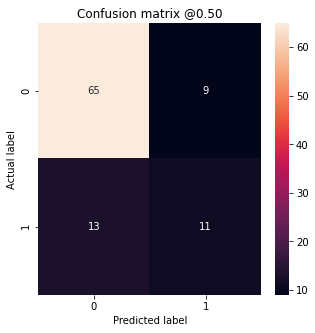

In [326]:
model = keras.Sequential([
      keras.layers.Dense(500, activation='relu',input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(800, activation='relu'),
      keras.layers.Dropout(0.7),
      keras.layers.Dense(900, activation='relu'),
      keras.layers.Dropout(0.7),
      keras.layers.Dense(500, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(200, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid')
  ])

experiment(model,EPOCHS = 300, PATIENCE=100, lr = 1e-4)

### Experiment 4

Restoring model weights from the end of the best epoch: 91.
Epoch 191: early stopping
4/4 [==============================] - 0s 3ms/step
loss :  0.5318021178245544

tp :  5.0

fp :  2.0

tn :  72.0

fn :  19.0

accuracy :  0.7857142686843872

precision :  0.7142857313156128

recall :  0.2083333283662796

auc :  0.7407094240188599

prc :  0.5273956060409546

Legitimate Transactions Detected (True Negatives):  72
Legitimate Transactions Incorrectly Detected (False Positives):  2
Fraudulent Transactions Missed (False Negatives):  19
Fraudulent Transactions Detected (True Positives):  5
Total Fraudulent Transactions:  24


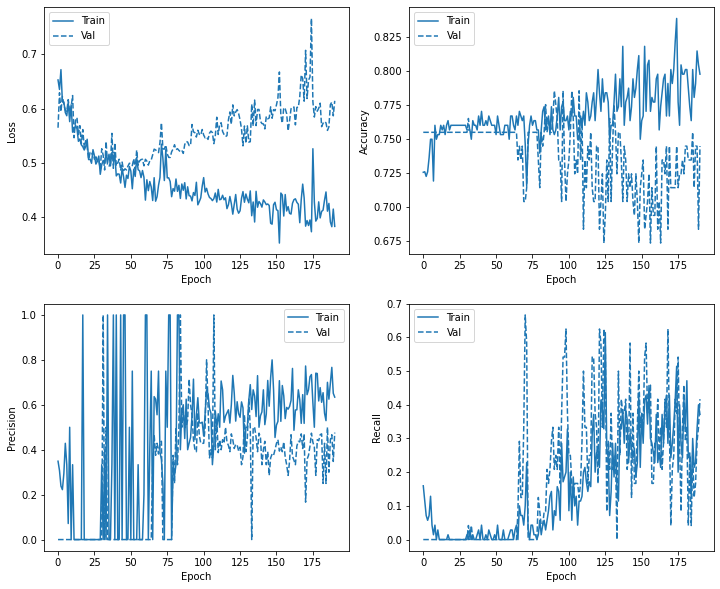

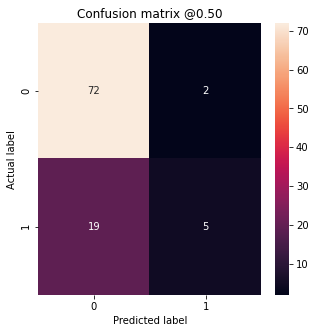

In [327]:
model = keras.Sequential([
      keras.layers.Dense(500, activation='relu',input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.6),
      keras.layers.Dense(800, activation='relu'),
      keras.layers.Dropout(0.7),
      keras.layers.Dense(900, activation='relu'),
      keras.layers.Dropout(0.7),
      keras.layers.Dense(500, activation='relu'),
      keras.layers.Dropout(0.6),
      keras.layers.Dense(200, activation='relu'),
      keras.layers.Dropout(0.6),
      keras.layers.Dense(1, activation='sigmoid')
  ])

experiment(model,EPOCHS = 300, PATIENCE=100, lr = 1e-4)

### Experiment 5

Restoring model weights from the end of the best epoch: 19.
Epoch 119: early stopping
4/4 [==============================] - 0s 5ms/step
loss :  0.49952977895736694

tp :  10.0

fp :  8.0

tn :  66.0

fn :  14.0

accuracy :  0.7755101919174194

precision :  0.5555555820465088

recall :  0.4166666567325592

auc :  0.7401463985443115

prc :  0.4333496391773224

Legitimate Transactions Detected (True Negatives):  66
Legitimate Transactions Incorrectly Detected (False Positives):  8
Fraudulent Transactions Missed (False Negatives):  14
Fraudulent Transactions Detected (True Positives):  10
Total Fraudulent Transactions:  24


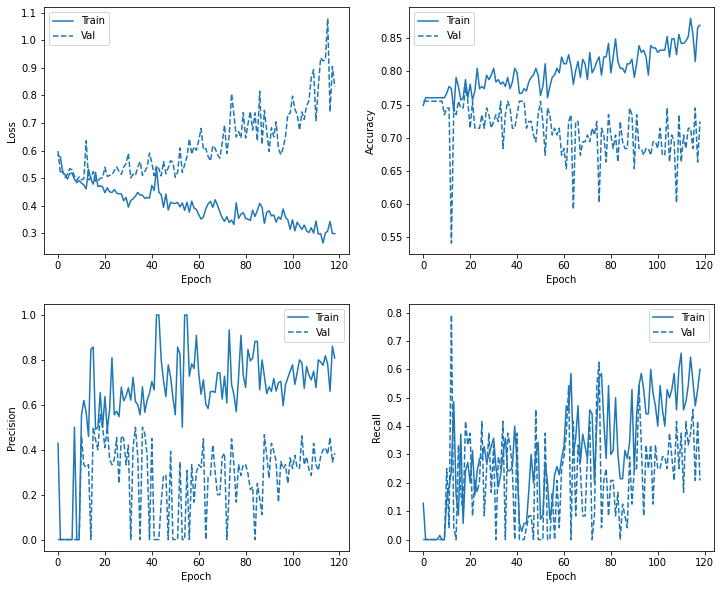

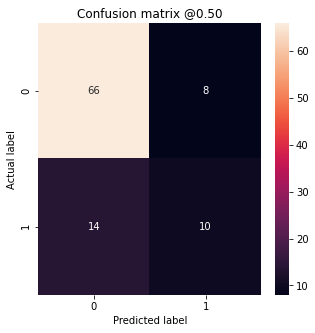

In [328]:
model = keras.Sequential([
      keras.layers.Dense(500, activation='relu',input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(800, activation='relu'),      
      keras.layers.Dense(900, activation='relu'),      
      keras.layers.Dense(500, activation='relu'),      
      keras.layers.Dense(200, activation='relu'),      
      keras.layers.Dense(1, activation='sigmoid')
  ])

experiment(model,EPOCHS = 300, PATIENCE=100, lr = 1e-4)

### Experiment 6

Restoring model weights from the end of the best epoch: 95.
Epoch 195: early stopping
4/4 [==============================] - 0s 0s/step
loss :  1.9814714193344116

tp :  13.0

fp :  8.0

tn :  66.0

fn :  11.0

accuracy :  0.8061224222183228

precision :  0.6190476417541504

recall :  0.5416666865348816

auc :  0.7319820523262024

prc :  0.48608890175819397

Legitimate Transactions Detected (True Negatives):  66
Legitimate Transactions Incorrectly Detected (False Positives):  8
Fraudulent Transactions Missed (False Negatives):  11
Fraudulent Transactions Detected (True Positives):  13
Total Fraudulent Transactions:  24


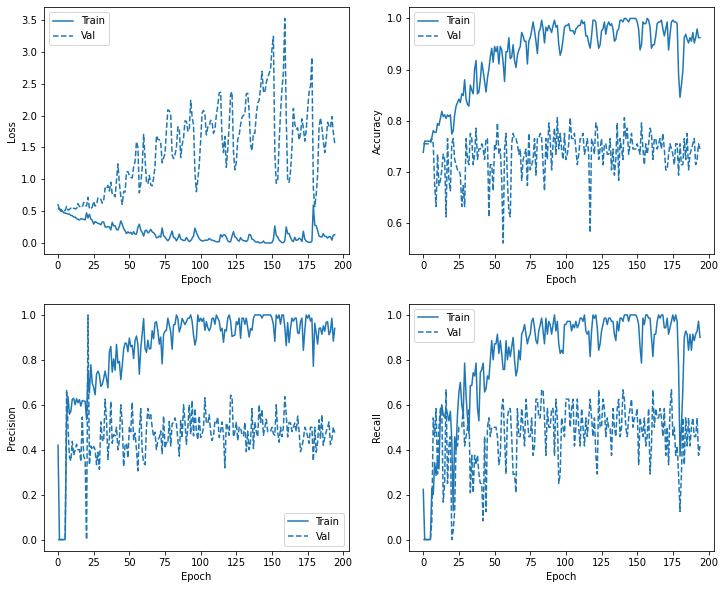

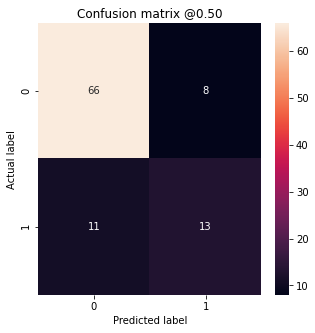

In [329]:
model = keras.Sequential([
      keras.layers.Dense(500, activation='relu',input_shape=(X_train.shape[-1],)),      
      keras.layers.Dense(800, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(900, activation='relu'),      
      keras.layers.Dense(500, activation='relu'),      
      keras.layers.Dense(200, activation='relu'),      
      keras.layers.Dense(1, activation='sigmoid')
  ])

experiment(model,EPOCHS = 300, PATIENCE=100, lr = 1e-4)

### Experiment 7

Restoring model weights from the end of the best epoch: 30.
Epoch 80: early stopping
4/4 [==============================] - 0s 4ms/step
loss :  0.5792644619941711

tp :  8.0

fp :  7.0

tn :  67.0

fn :  16.0

accuracy :  0.7653061151504517

precision :  0.5333333611488342

recall :  0.3333333432674408

auc :  0.7229729890823364

prc :  0.42530572414398193

Legitimate Transactions Detected (True Negatives):  67
Legitimate Transactions Incorrectly Detected (False Positives):  7
Fraudulent Transactions Missed (False Negatives):  16
Fraudulent Transactions Detected (True Positives):  8
Total Fraudulent Transactions:  24


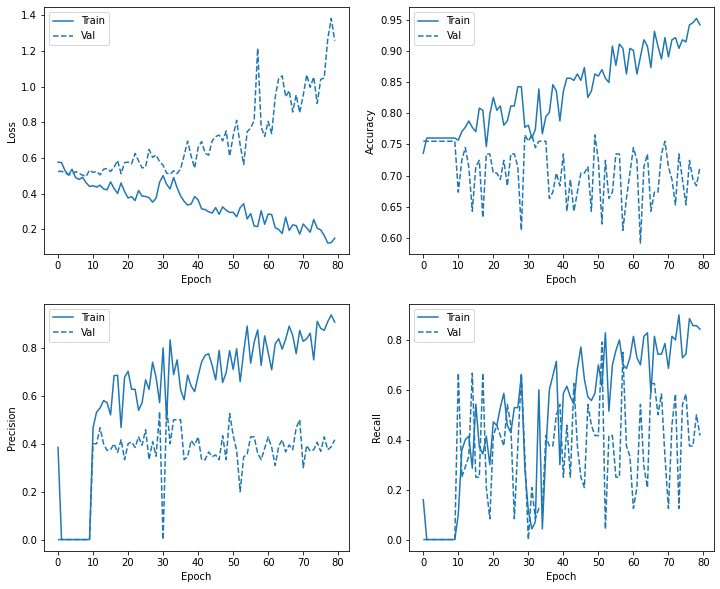

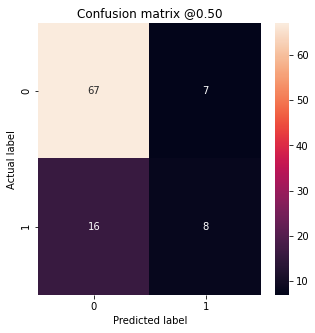

In [336]:
model = keras.Sequential([
      keras.layers.Dense(500, activation='relu',input_shape=(X_train.shape[-1],)),      
      keras.layers.Dense(800, activation='relu'),
      keras.layers.Dropout(0.65),
      keras.layers.Dense(900, activation='relu'),      
      keras.layers.Dense(500, activation='relu'),      
      keras.layers.Dense(200, activation='relu'),      
      keras.layers.Dense(1, activation='sigmoid')
  ])

experiment(model,EPOCHS = 300, PATIENCE=50, lr = 1e-4)

### Experiment 8

Restoring model weights from the end of the best epoch: 53.
Epoch 103: early stopping
4/4 [==============================] - 0s 1ms/step
loss :  0.8797948956489563

tp :  7.0

fp :  5.0

tn :  69.0

fn :  17.0

accuracy :  0.7755101919174194

precision :  0.5833333134651184

recall :  0.2916666567325592

auc :  0.7114302515983582

prc :  0.4232670068740845

Legitimate Transactions Detected (True Negatives):  69
Legitimate Transactions Incorrectly Detected (False Positives):  5
Fraudulent Transactions Missed (False Negatives):  17
Fraudulent Transactions Detected (True Positives):  7
Total Fraudulent Transactions:  24


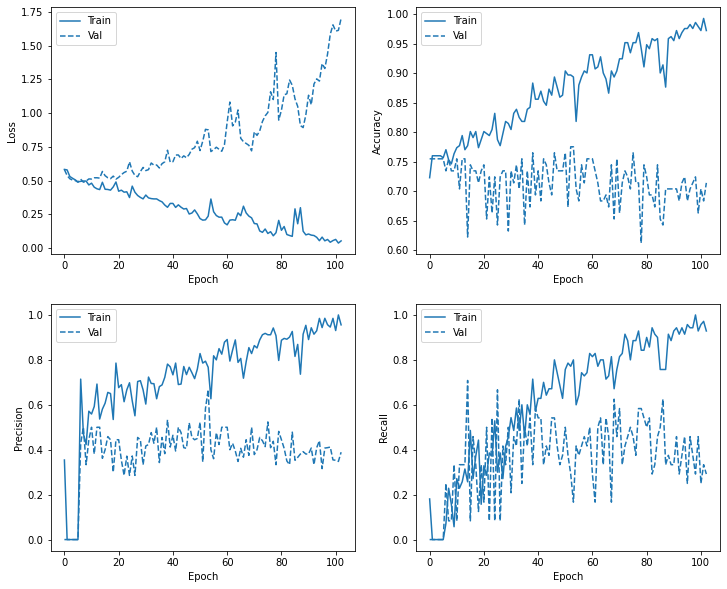

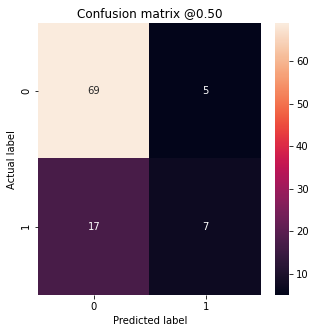

In [338]:
model = keras.Sequential([
      keras.layers.Dense(240, activation='relu',input_shape=(X_train.shape[-1],)),      
      keras.layers.Dense(360, activation='relu'),
      keras.layers.Dropout(0.6),      
      keras.layers.Dense(120, activation='relu'),      
      keras.layers.Dense(86, activation='relu'),      
      keras.layers.Dense(1, activation='sigmoid')
  ])

experiment(model,EPOCHS = 300, PATIENCE=50, lr = 1e-4)

### Experiment 9

Restoring model weights from the end of the best epoch: 150.
Epoch 250: early stopping
4/4 [==============================] - 0s 6ms/step
loss :  0.6585878729820251

tp :  11.0

fp :  7.0

tn :  67.0

fn :  13.0

accuracy :  0.795918345451355

precision :  0.6111111044883728

recall :  0.4583333432674408

auc :  0.71396404504776

prc :  0.45388126373291016

Legitimate Transactions Detected (True Negatives):  67
Legitimate Transactions Incorrectly Detected (False Positives):  7
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  11
Total Fraudulent Transactions:  24


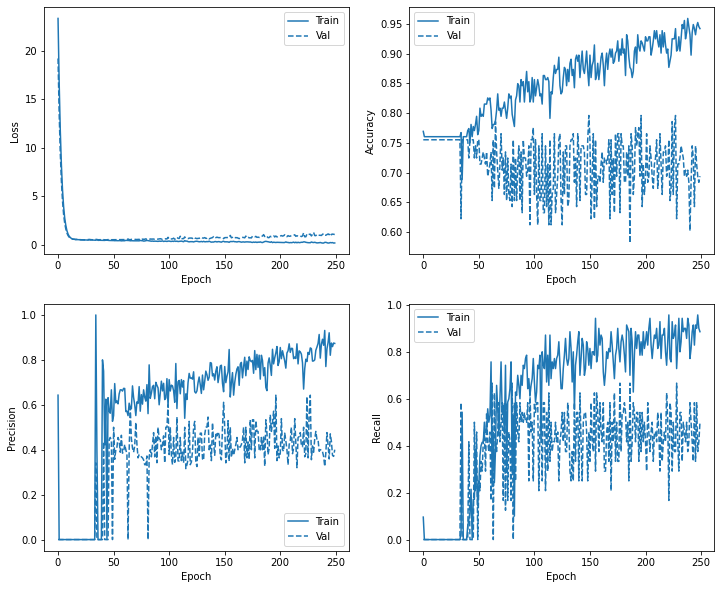

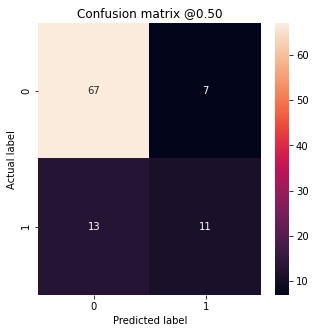

In [361]:
model = keras.Sequential([
      keras.layers.Dense(170, activation='relu',input_shape=(X_train.shape[-1],)),    
      keras.layers.Dropout(0.2), 
      keras.layers.Dense(units = 320, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02)),  
      keras.layers.Dense(units = 480, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02)),  
      keras.layers.Dense(units = 320, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02)),  
      keras.layers.Dropout(0.2),
      keras.layers.Dense(units = 280, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02)),  
      keras.layers.Dense(units = 120, activation = 'relu'),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(1, activation='sigmoid')
  ])

experiment(model,EPOCHS = 300, PATIENCE=100, lr = 1e-4)

### Experiment 10 --- Final

Restoring model weights from the end of the best epoch: 86.
Epoch 136: early stopping
4/4 [==============================] - 0s 5ms/step
loss :  1.3249627351760864

tp :  9.0

fp :  5.0

tn :  69.0

fn :  15.0

accuracy :  0.795918345451355

precision :  0.6428571343421936

recall :  0.375

auc :  0.6796172261238098

prc :  0.44026875495910645

Legitimate Transactions Detected (True Negatives):  69
Legitimate Transactions Incorrectly Detected (False Positives):  5
Fraudulent Transactions Missed (False Negatives):  15
Fraudulent Transactions Detected (True Positives):  9
Total Fraudulent Transactions:  24


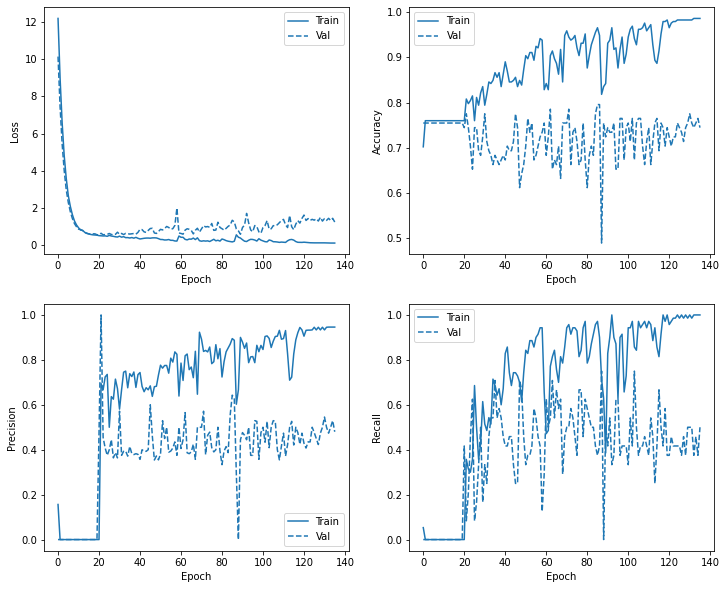

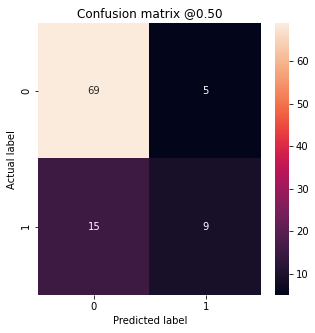

In [168]:
model = keras.Sequential([
      keras.layers.Dense(170, activation='relu',input_shape=(X_train.shape[-1],)),    
      keras.layers.Dense(units = 240, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.01)),  
      keras.layers.Dense(units = 320, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.01)),  
      keras.layers.Dense(units = 480, activation = 'relu'),  
      keras.layers.Dense(units = 560, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.01)),  
      keras.layers.Dense(units = 240, activation = 'relu'),
      keras.layers.Dense(units = 120, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02)),  
      keras.layers.Dense(units = 24, activation = 'relu'),
      keras.layers.Dense(1, activation='sigmoid')
  ])

experiment(model,EPOCHS = 500, PATIENCE=50, lr = 1e-4)

In [169]:
sm = SMOTE(random_state=42,k_neighbors=3)

X_res, y_res = sm.fit_resample(X_train, y_train)

Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping
4/4 [==============================] - 0s 0s/step
loss :  17.28571128845215

tp :  6.0

fp :  0.0

tn :  74.0

fn :  18.0

accuracy :  0.8163265585899353

precision :  1.0

recall :  0.25

auc :  0.7317004799842834

prc :  0.5492756366729736

Legitimate Transactions Detected (True Negatives):  74
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  18
Fraudulent Transactions Detected (True Positives):  6
Total Fraudulent Transactions:  24


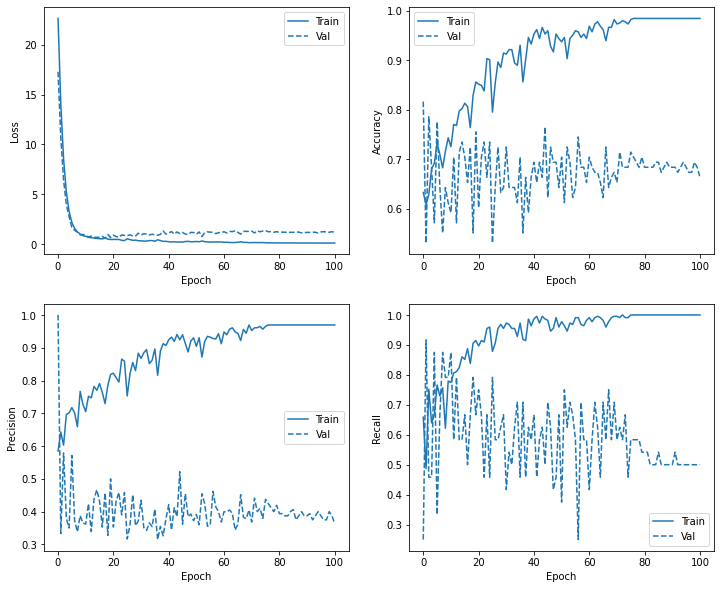

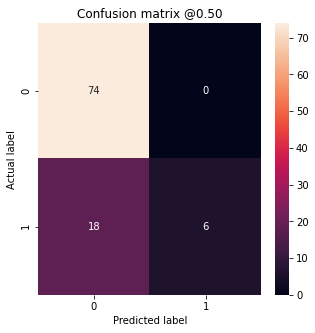

In [181]:
model = keras.Sequential([
      keras.layers.Dense(170, activation='relu',input_shape=(X_train.shape[-1],)),    
      keras.layers.Dense(units = 240, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02)),  
      keras.layers.Dense(units = 320, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.025)),  
      keras.layers.Dense(units = 480, activation = 'relu'),  
      keras.layers.Dense(units = 560, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.025)),  
      keras.layers.Dense(units = 240, activation = 'relu'),
      keras.layers.Dense(units = 120, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02)),  
      keras.layers.Dense(units = 24, activation = 'relu'),
      keras.layers.Dense(1, activation='sigmoid')
  ])

experimentSD(model,EPOCHS = 500, PATIENCE=100, lr = 1e-4)

In [180]:
model.save('saved_model/best_model_aucc82')

INFO:tensorflow:Assets written to: saved_model/best_model_aucc82\assets


In [ ]:
model = keras.Sequential([
      keras.layers.Dense(170, activation='relu',input_shape=(X_train.shape[-1],)),    
      keras.layers.Dense(units = 240, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.01)),  
      keras.layers.Dropout(0.3),
      keras.layers.Dense(units = 320, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.15)),  
      keras.layers.Dense(units = 480, activation = 'relu'),  
      keras.layers.Dropout(0.3),
      keras.layers.Dense(units = 560, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.15)),  
      keras.layers.Dense(units = 240, activation = 'relu'),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(units = 120, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.15)),  
      keras.layers.Dense(units = 24, activation = 'relu'),
      keras.layers.Dense(1, activation='sigmoid')
  ])

experimentSD(model,EPOCHS = 500, PATIENCE=100, lr = 1e-4)

### Generating more data using SDV

### Experiment 11

Restoring model weights from the end of the best epoch: 78.
Epoch 178: early stopping
4/4 [==============================] - 0s 4ms/step
loss :  0.6880887150764465

tp :  10.0

fp :  7.0

tn :  67.0

fn :  14.0

accuracy :  0.7857142686843872

precision :  0.5882353186607361

recall :  0.4166666567325592

auc :  0.7201577425003052

prc :  0.5267915725708008

Legitimate Transactions Detected (True Negatives):  67
Legitimate Transactions Incorrectly Detected (False Positives):  7
Fraudulent Transactions Missed (False Negatives):  14
Fraudulent Transactions Detected (True Positives):  10
Total Fraudulent Transactions:  24


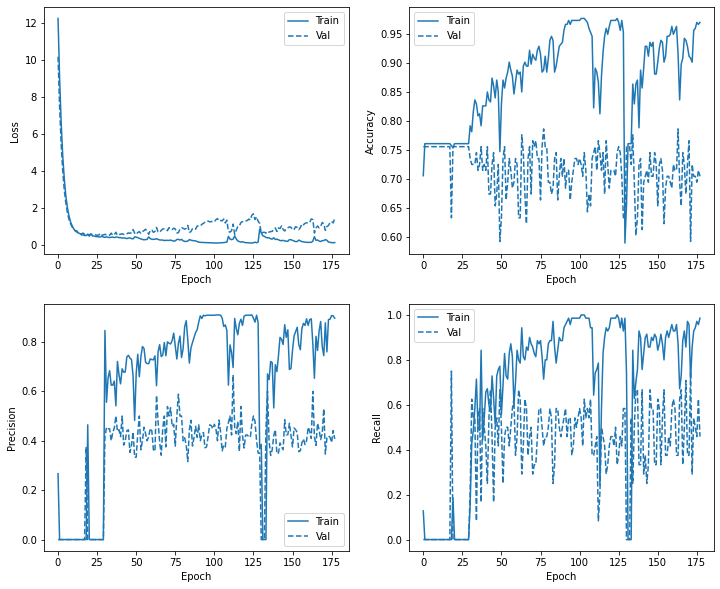

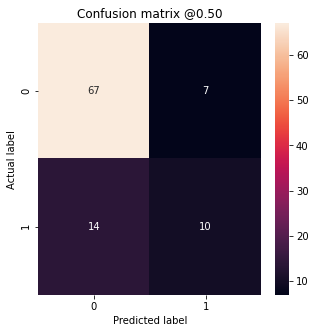

In [386]:
model = keras.Sequential([
      keras.layers.Dense(170, activation='relu',input_shape=(X_train.shape[-1],)),    
      keras.layers.Dense(units = 240, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.01)),  
      keras.layers.Dense(units = 320, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.01)),  
      keras.layers.Dense(units = 480, activation = 'relu'),  
      keras.layers.Dense(units = 560, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.01)),  
      keras.layers.Dense(units = 240, activation = 'relu'),
      keras.layers.Dense(units = 120, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02)),  
      keras.layers.Dense(units = 24, activation = 'relu'),
      keras.layers.Dense(1, activation='sigmoid')
  ])

experiment(model,EPOCHS = 500, PATIENCE=100, lr = 1e-4)

### Functional API Experiments

Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping
4/4 [==============================] - 0s 6ms/step
loss :  9.777576446533203

tp :  0.0

fp :  0.0

tn :  74.0

fn :  24.0

accuracy :  0.7551020383834839

precision :  0.0

recall :  0.0

auc :  0.7809684872627258

prc :  0.5607938170433044

Legitimate Transactions Detected (True Negatives):  74
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  24
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  24


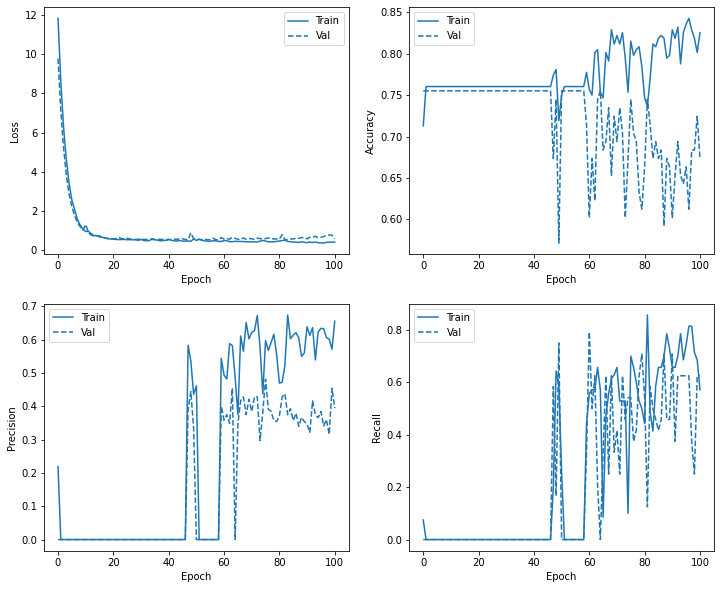

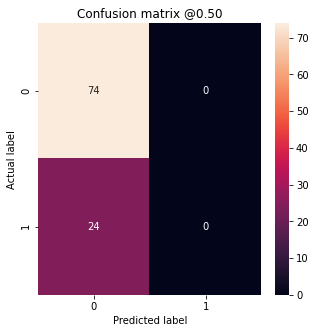

In [389]:
inputs = keras.Input(shape=(X_train.shape[1]))
x = keras.layers.Dense(units = 240, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.01))(inputs)
x = keras.layers.Dense(units = 320, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.01))(x)
x = keras.layers.Dense(units = 480, activation = 'relu')(x)
x = keras.layers.Dense(units = 560, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.01))(x)
x = keras.layers.Dense(units = 240, activation = 'relu')(x)
x = keras.layers.Dense(units = 120, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02))(x)
int_features = keras.layers.Dense(units = 24, activation = 'relu')(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)
x = keras.layers.concatenate([int_features,x])
x = keras.layers.Dense(units = 480, activation = 'relu')(x)
x = keras.layers.Dense(units = 360, activation = 'relu')(x)
x = keras.layers.Dense(units = 120, activation = 'relu')(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs, name="functionalAPI_model")


experiment(model,EPOCHS = 500, PATIENCE=100, lr = 1e-4)

## Baseline model

In [261]:
EPOCHS = 100


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

In [262]:
model = make_model()
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_174 (Dense)           (None, 500)               59000     
                                                                 
 dropout_66 (Dropout)        (None, 500)               0         
                                                                 
 dense_175 (Dense)           (None, 800)               400800    
                                                                 
 dropout_67 (Dropout)        (None, 800)               0         
                                                                 
 dense_176 (Dense)           (None, 900)               720900    
                                                                 
 dropout_68 (Dropout)        (None, 900)               0         
                                                                 
 dense_177 (Dense)           (None, 500)             

Test run the model:

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training:

In [263]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### Train the model

In [264]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train,
    y_train,
    
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_test, y_test))

Epoch 1/100
10/10 [==============================] - 2s 93ms/step - loss: 0.6322 - tp: 12.0000 - fp: 36.0000 - tn: 186.0000 - fn: 58.0000 - accuracy: 0.6781 - precision: 0.2500 - recall: 0.1714 - auc: 0.5282 - prc: 0.2596 - val_loss: 0.5674 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 74.0000 - val_fn: 24.0000 - val_accuracy: 0.7551 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6427 - val_prc: 0.4289
Epoch 2/100
10/10 [==============================] - 0s 22ms/step - loss: 0.5527 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 222.0000 - fn: 70.0000 - accuracy: 0.7603 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5407 - prc: 0.2960 - val_loss: 0.5459 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 74.0000 - val_fn: 24.0000 - val_accuracy: 0.7551 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6943 - val_prc: 0.4885
Epoch 3/100
10/10 [==============================] - 0s 21ms/step - loss: 0.5519 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 222

10/10 [==============================] - 0s 14ms/step - loss: 0.4602 - tp: 7.0000 - fp: 1.0000 - tn: 221.0000 - fn: 63.0000 - accuracy: 0.7808 - precision: 0.8750 - recall: 0.1000 - auc: 0.7762 - prc: 0.5127 - val_loss: 0.4931 - val_tp: 6.0000 - val_fp: 6.0000 - val_tn: 68.0000 - val_fn: 18.0000 - val_accuracy: 0.7551 - val_precision: 0.5000 - val_recall: 0.2500 - val_auc: 0.7309 - val_prc: 0.4822
Epoch 39/100
10/10 [==============================] - 0s 15ms/step - loss: 0.4530 - tp: 14.0000 - fp: 5.0000 - tn: 217.0000 - fn: 56.0000 - accuracy: 0.7911 - precision: 0.7368 - recall: 0.2000 - auc: 0.7948 - prc: 0.5256 - val_loss: 0.5006 - val_tp: 8.0000 - val_fp: 10.0000 - val_tn: 64.0000 - val_fn: 16.0000 - val_accuracy: 0.7347 - val_precision: 0.4444 - val_recall: 0.3333 - val_auc: 0.7294 - val_prc: 0.4674
Epoch 40/100
10/10 [==============================] - 0s 15ms/step - loss: 0.4554 - tp: 14.0000 - fp: 9.0000 - tn: 213.0000 - fn: 56.0000 - accuracy: 0.7774 - precision: 0.6087 - reca

### Check training history

In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in the [Overfit and underfit](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit) tutorial.

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

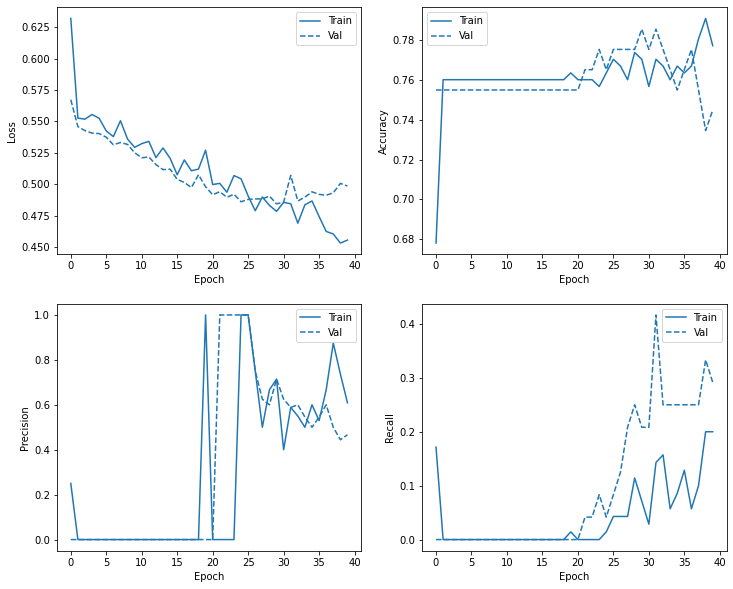

In [266]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels, where the X axis is the predicted label and the Y axis is the actual label:

In [267]:
train_predictions_baseline = model.predict(X_train)
test_predictions_baseline = model.predict(X_test)

4/4 [==============================] - 0s 5ms/step


Evaluate your model on the test dataset and display the results for the metrics you created above:

loss :  0.4843246340751648
tp :  5.0
fp :  2.0
tn :  72.0
fn :  19.0
accuracy :  0.7857142686843872
precision :  0.7142857313156128
recall :  0.2083333283662796
auc :  0.7452139854431152
prc :  0.528641939163208

Legitimate Transactions Detected (True Negatives):  72
Legitimate Transactions Incorrectly Detected (False Positives):  2
Fraudulent Transactions Missed (False Negatives):  19
Fraudulent Transactions Detected (True Positives):  5
Total Fraudulent Transactions:  24


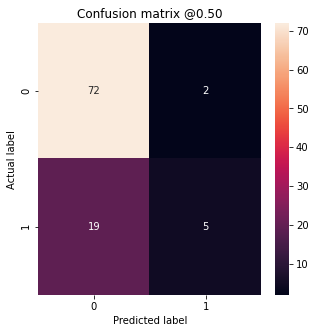

In [269]:
baseline_results = model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

If the model had predicted everything perfectly, this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [116]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  #plt.xlim([-0.5,20])
  #plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

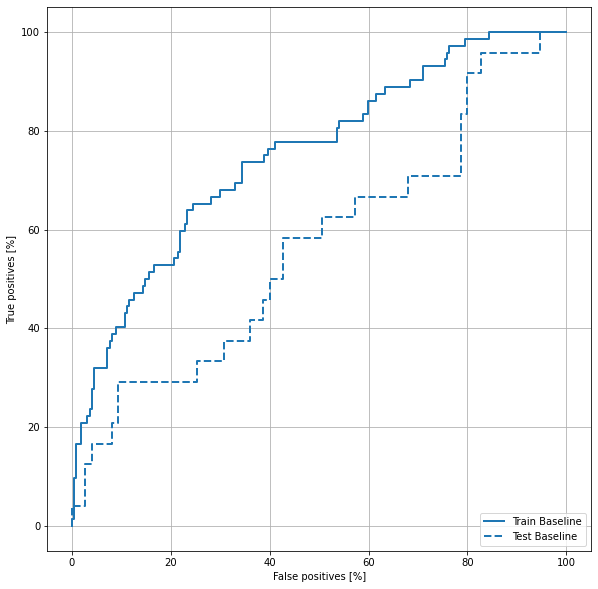

In [117]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC

Now plot the [AUPRC](https://developers.google.com/machine-learning/glossary?hl=en#PR_AUC). Area under the interpolated precision-recall curve, obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.


In [40]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

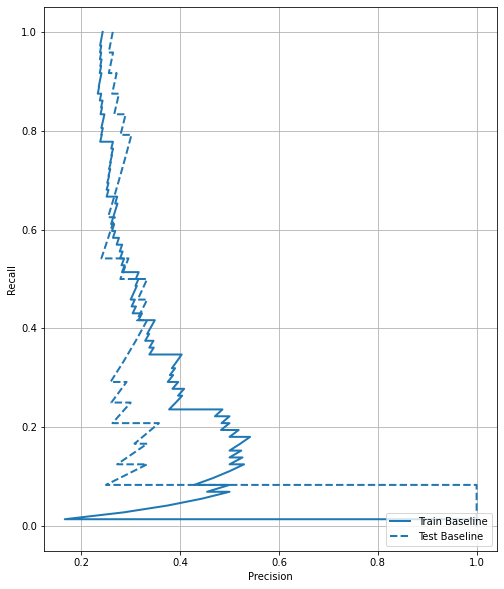

In [41]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [214]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test,test_predictions_baseline)

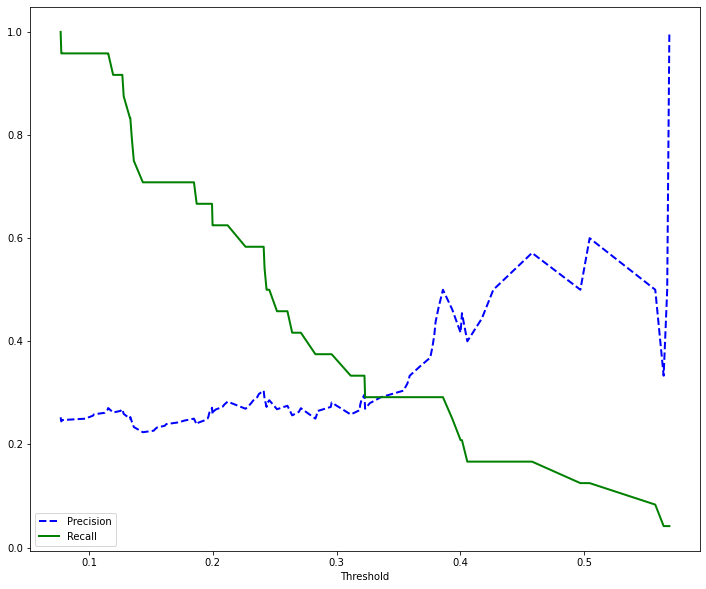

In [215]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
#plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
#[...]  # beautify the figure: add grid, legend, axis, labels, and circles
plt.xlabel('Threshold')
plt.legend()
plt.show()

In [216]:
idx_for_95_recall = recalls[recalls>=0.958].shape[0]-1
threshold_for_95_recall = thresholds[idx_for_95_recall]
print(f" Threshold for 75% recall {threshold_for_95_recall}")
print(f"Precision: {precisions[idx_for_95_recall]}")
print(f"Recall: {recalls[idx_for_95_recall]}")


 Threshold for 75% recall 0.11545625329017639
Precision: 0.27058823529411763
Recall: 0.9583333333333334


In [217]:
confusion_matrix(y_test,np.where(test_predictions_baseline > idx_for_95_recall,1,0))

array([[75,  0],
       [24,  0]], dtype=int64)

Legitimate Transactions Detected (True Negatives):  75
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  24
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  24


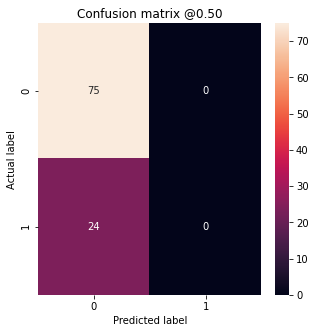

In [218]:
plot_cm(y_test, np.where(test_predictions_baseline > idx_for_95_recall,1,0))

In [220]:
precisions

array([0.25263158, 0.24468085, 0.24731183, 0.25      , 0.25274725,
       0.25555556, 0.25842697, 0.26136364, 0.26436782, 0.26744186,
       0.27058824, 0.26190476, 0.26506024, 0.26829268, 0.25925926,
       0.25      , 0.25316456, 0.24358974, 0.23376623, 0.22368421,
       0.22666667, 0.22972973, 0.23287671, 0.23611111, 0.23943662,
       0.24285714, 0.24637681, 0.25      , 0.23880597, 0.24242424,
       0.24615385, 0.25      , 0.25396825, 0.25806452, 0.26229508,
       0.26666667, 0.27118644, 0.25862069, 0.26315789, 0.26785714,
       0.27272727, 0.27777778, 0.28301887, 0.26923077, 0.2745098 ,
       0.28      , 0.28571429, 0.29166667, 0.29787234, 0.30434783,
       0.28888889, 0.27272727, 0.27906977, 0.28571429, 0.26829268,
       0.275     , 0.25641026, 0.26315789, 0.27027027, 0.25      ,
       0.25714286, 0.26470588, 0.27272727, 0.28125   , 0.25806452,
       0.26666667, 0.27586207, 0.28571429, 0.2962963 , 0.26923077,
       0.28      , 0.29166667, 0.30434783, 0.31818182, 0.33333

In [225]:
recalls

array([1.        , 0.95833333, 0.95833333, 0.95833333, 0.95833333,
       0.95833333, 0.95833333, 0.95833333, 0.95833333, 0.95833333,
       0.95833333, 0.91666667, 0.91666667, 0.91666667, 0.875     ,
       0.83333333, 0.83333333, 0.79166667, 0.75      , 0.70833333,
       0.70833333, 0.70833333, 0.70833333, 0.70833333, 0.70833333,
       0.70833333, 0.70833333, 0.70833333, 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.625     , 0.625     , 0.625     ,
       0.625     , 0.625     , 0.625     , 0.58333333, 0.58333333,
       0.58333333, 0.58333333, 0.58333333, 0.58333333, 0.58333333,
       0.54166667, 0.5       , 0.5       , 0.5       , 0.45833333,
       0.45833333, 0.41666667, 0.41666667, 0.41666667, 0.375     ,
       0.375     , 0.375     , 0.375     , 0.375     , 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.29166667,
       0.29166667, 0.29166667, 0.29166667, 0.29166667, 0.29166

In [222]:
thresholds

array([0.07701969, 0.07756533, 0.07838825, 0.09727777, 0.09980319,
       0.10292304, 0.10405537, 0.11258928, 0.11378869, 0.11495787,
       0.11545625, 0.11943076, 0.12540522, 0.12687275, 0.12797417,
       0.13298361, 0.13331328, 0.13460614, 0.13616149, 0.1434508 ,
       0.15218273, 0.15336967, 0.15493862, 0.16099834, 0.16240257,
       0.1724107 , 0.1771662 , 0.18473347, 0.18693572, 0.18843684,
       0.1926816 , 0.19567904, 0.1964506 , 0.19677384, 0.19730687,
       0.19879782, 0.1993217 , 0.19975877, 0.20007293, 0.20241722,
       0.20768194, 0.2094756 , 0.21193098, 0.22641556, 0.22887622,
       0.23089293, 0.23279239, 0.23586689, 0.23721722, 0.24106508,
       0.24176575, 0.24340641, 0.24362019, 0.24560542, 0.25181377,
       0.26023853, 0.26409888, 0.26947707, 0.27110195, 0.28286207,
       0.28387287, 0.28446627, 0.2952684 , 0.29596868, 0.31137723,
       0.31875676, 0.3189585 , 0.31996813, 0.32248953, 0.32301208,
       0.32678795, 0.33584213, 0.35402697, 0.35717884, 0.35907

In [224]:
0.1/(0.1+24)

0.004149377593360996

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

## Class weights

### Calculate class weights

The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [118]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total )

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.66
Weight for class 1: 4.11


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `tf.keras.optimizers.SGD`, may fail. The optimizer used here, `tf.keras.optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [119]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train,
    y_train,    
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_test, y_test),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100
10/10 [==============================] - 3s 141ms/step - loss: 1.5947 - tp: 25.0000 - fp: 72.0000 - tn: 227.0000 - fn: 71.0000 - accuracy: 0.6380 - precision: 0.2577 - recall: 0.2604 - auc: 0.4996 - prc: 0.2496 - val_loss: 0.6709 - val_tp: 4.0000 - val_fp: 19.0000 - val_tn: 56.0000 - val_fn: 20.0000 - val_accuracy: 0.6061 - val_precision: 0.1739 - val_recall: 0.1667 - val_auc: 0.4278 - val_prc: 0.2038
Epoch 2/100
10/10 [==============================] - 0s 21ms/step - loss: 1.4863 - tp: 24.0000 - fp: 67.0000 - tn: 157.0000 - fn: 48.0000 - accuracy: 0.6115 - precision: 0.2637 - recall: 0.3333 - auc: 0.4686 - prc: 0.2262 - val_loss: 0.6636 - val_tp: 5.0000 - val_fp: 19.0000 - val_tn: 56.0000 - val_fn: 19.0000 - val_accuracy: 0.6162 - val_precision: 0.2083 - val_recall: 0.2083 - val_auc: 0.4408 - val_prc: 0.2066
Epoch 3/100
10/10 [==============================] - 0s 21ms/step - loss: 1.5016 - tp: 20.0000 - fp: 71.0000 - tn: 153.0000 - fn: 52.0000 - accuracy: 0.5845 - precisio

Epoch 21/100
10/10 [==============================] - 0s 21ms/step - loss: 0.9334 - tp: 55.0000 - fp: 128.0000 - tn: 96.0000 - fn: 17.0000 - accuracy: 0.5101 - precision: 0.3005 - recall: 0.7639 - auc: 0.6682 - prc: 0.4202 - val_loss: 0.8404 - val_tp: 15.0000 - val_fp: 44.0000 - val_tn: 31.0000 - val_fn: 9.0000 - val_accuracy: 0.4646 - val_precision: 0.2542 - val_recall: 0.6250 - val_auc: 0.5308 - val_prc: 0.2875
Epoch 22/100
10/10 [==============================] - 0s 19ms/step - loss: 0.9209 - tp: 54.0000 - fp: 109.0000 - tn: 115.0000 - fn: 18.0000 - accuracy: 0.5709 - precision: 0.3313 - recall: 0.7500 - auc: 0.6821 - prc: 0.4417 - val_loss: 0.8423 - val_tp: 15.0000 - val_fp: 44.0000 - val_tn: 31.0000 - val_fn: 9.0000 - val_accuracy: 0.4646 - val_precision: 0.2542 - val_recall: 0.6250 - val_auc: 0.5306 - val_prc: 0.2932
Epoch 23/100
10/10 [==============================] - 0s 27ms/step - loss: 0.9928 - tp: 52.0000 - fp: 109.0000 - tn: 115.0000 - fn: 20.0000 - accuracy: 0.5642 - prec

Epoch 41/100
10/10 [==============================] - 0s 20ms/step - loss: 0.9174 - tp: 49.0000 - fp: 106.0000 - tn: 118.0000 - fn: 23.0000 - accuracy: 0.5642 - precision: 0.3161 - recall: 0.6806 - auc: 0.6883 - prc: 0.4497 - val_loss: 0.8552 - val_tp: 15.0000 - val_fp: 43.0000 - val_tn: 32.0000 - val_fn: 9.0000 - val_accuracy: 0.4747 - val_precision: 0.2586 - val_recall: 0.6250 - val_auc: 0.5406 - val_prc: 0.3111
Epoch 42/100
10/10 [==============================] - 0s 19ms/step - loss: 0.9488 - tp: 54.0000 - fp: 115.0000 - tn: 109.0000 - fn: 18.0000 - accuracy: 0.5507 - precision: 0.3195 - recall: 0.7500 - auc: 0.6736 - prc: 0.3803 - val_loss: 0.8558 - val_tp: 15.0000 - val_fp: 43.0000 - val_tn: 32.0000 - val_fn: 9.0000 - val_accuracy: 0.4747 - val_precision: 0.2586 - val_recall: 0.6250 - val_auc: 0.5431 - val_prc: 0.3119
Epoch 43/100
10/10 [==============================] - 0s 19ms/step - loss: 0.9518 - tp: 54.0000 - fp: 118.0000 - tn: 106.0000 - fn: 18.0000 - accuracy: 0.5405 - pre

### Check training history

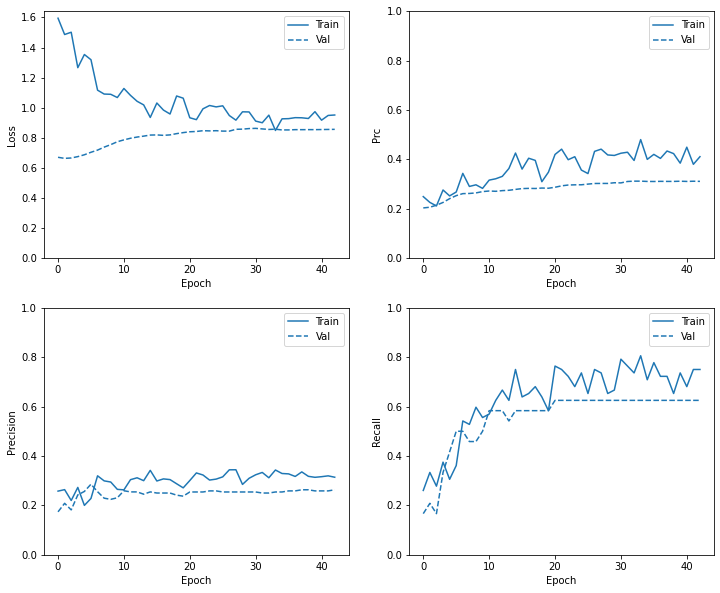

In [120]:
plot_metrics(weighted_history)

### Evaluate metrics

In [121]:
train_predictions_weighted = weighted_model.predict(X_train)
test_predictions_weighted = weighted_model.predict(X_test)

4/4 [==============================] - 0s 2ms/step


loss :  0.8557107448577881
tp :  15.0
fp :  45.0
tn :  30.0
fn :  9.0
accuracy :  0.4545454680919647
precision :  0.25
recall :  0.625
auc :  0.5433333516120911
prc :  0.3122093081474304

Legitimate Transactions Detected (True Negatives):  30
Legitimate Transactions Incorrectly Detected (False Positives):  45
Fraudulent Transactions Missed (False Negatives):  9
Fraudulent Transactions Detected (True Positives):  15
Total Fraudulent Transactions:  24


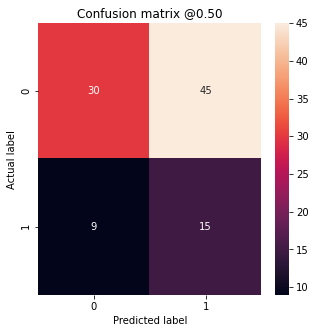

In [122]:
weighted_results = weighted_model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

### Plot Precision and recall curve

In [130]:
y_test.shape

(99,)

In [135]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test,test_predictions_weighted)

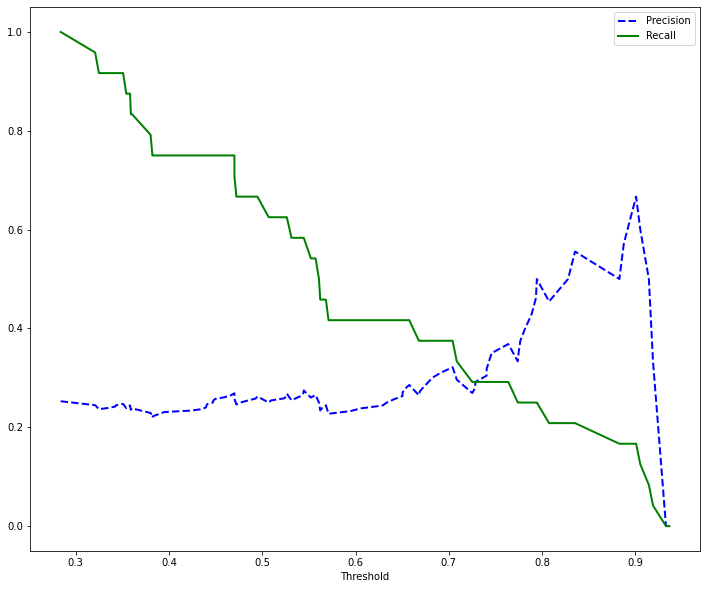

In [187]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
#plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
#[...]  # beautify the figure: add grid, legend, axis, labels, and circles
plt.xlabel('Threshold')
plt.legend()
plt.show()

In [199]:
idx_for_75_recall = recalls[recalls>=0.75].shape[0]-1
threshold_for_75_recall = thresholds[idx_for_75_recall]
print(f" Threshold for 75% recall {threshold_for_75_recall}")
print(f"Precision: {precisions[idx_for_75_recall]}")
print(f"Recall: {recalls[idx_for_75_recall]}")


 Threshold for 75% recall 0.47001102566719055
Precision: 0.26865671641791045
Recall: 0.75


In [201]:
confusion_matrix(y_test,np.where(test_predictions_weighted > threshold_for_75_recall,1,0))

array([[26, 49],
       [ 7, 17]], dtype=int64)

Legitimate Transactions Detected (True Negatives):  26
Legitimate Transactions Incorrectly Detected (False Positives):  49
Fraudulent Transactions Missed (False Negatives):  7
Fraudulent Transactions Detected (True Positives):  17
Total Fraudulent Transactions:  24


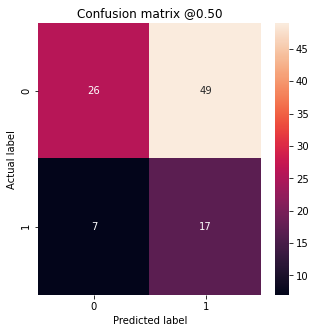

In [202]:
plot_cm(y_test, np.where(test_predictions_weighted > threshold_for_75_recall,1,0))

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade-offs between these different types of errors for your application.

### Plot the ROC

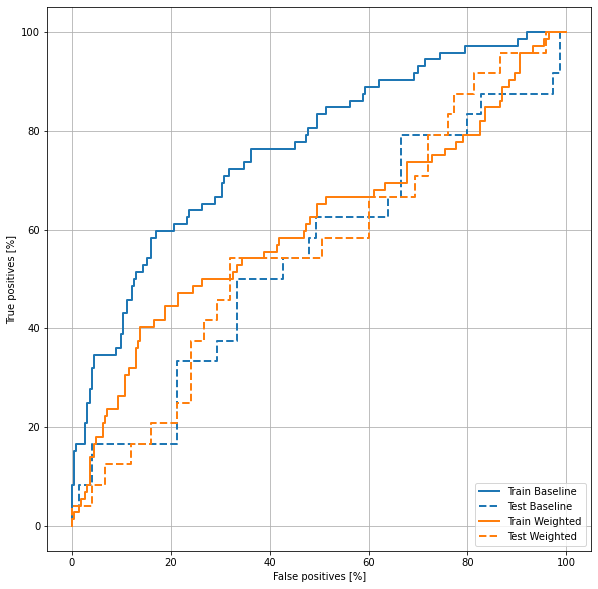

In [104]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

### Plot the AUPRC

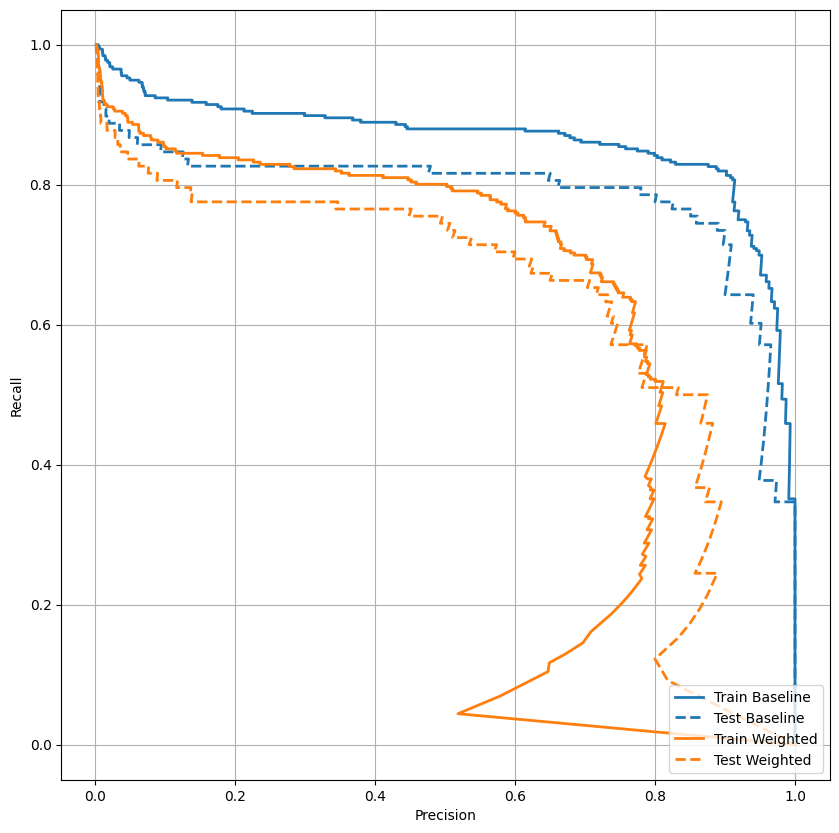

In [40]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

## Oversampling

### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [41]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### Using NumPy

You can balance the dataset manually by choosing the right number of random 
indices from the positive examples:

In [42]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181960, 29)

In [43]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363920, 29)

#### Using `tf.data`

If you're using `tf.data` the easiest way to produce balanced examples is to start with a `positive` and a `negative` dataset, and merge them. See [the tf.data guide](../../guide/data.ipynb) for more examples.

In [44]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

Each dataset provides `(feature, label)` pairs:

In [45]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [ 0.55048622  0.58281053 -0.18054636  1.93583095  0.29554659 -0.23724915
  0.03108875  0.14900966 -0.87832068 -0.17802301  2.09779545 -0.27353277
 -1.19726626 -1.95269012  0.43650731  1.5548122   1.78388368  1.22320993
 -1.93671114 -0.22109894 -0.01110755 -0.07843217 -0.08560816 -0.04293247
  0.76732118  0.15200643  0.06685898  0.18756067 -4.85856533]

Label:  1


Merge the two together using `tf.data.Dataset.sample_from_datasets`:

In [46]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [47]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.52490234375


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [48]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps. 

In [49]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 8s 22ms/step - loss: 0.3953 - tp: 266190.0000 - fp: 98443.0000 - tn: 243783.0000 - fn: 17890.0000 - accuracy: 0.8143 - precision: 0.7300 - recall: 0.9370 - auc: 0.9499 - prc: 0.9521 - val_loss: 0.2553 - val_tp: 71.0000 - val_fp: 1519.0000 - val_tn: 43972.0000 - val_fn: 7.0000 - val_accuracy: 0.9665 - val_precision: 0.0447 - val_recall: 0.9103 - val_auc: 0.9714 - val_prc: 0.7439
Epoch 2/100
278/278 [==============================] - 6s 21ms/step - loss: 0.1833 - tp: 267167.0000 - fp: 16878.0000 - tn: 267871.0000 - fn: 17428.0000 - accuracy: 0.9397 - precision: 0.9406 - recall: 0.9388 - auc: 0.9824 - prc: 0.9856 - val_loss: 0.1188 - val_tp: 70.0000 - val_fp: 945.0000 - val_tn: 44546.0000 - val_fn: 8.0000 - val_accuracy: 0.9791 - val_precision: 0.0690 - val_recall: 0.8974 - val_auc: 0.9720 - val_prc: 0.7543
Epoch 3/100
278/278 [==============================] - 6s 21ms/step - loss: 0.1389 - tp: 270484.0000 - fp: 10829.0000 - tn: 27356

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight. 

This smoother gradient signal makes it easier to train the model.

### Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data. 

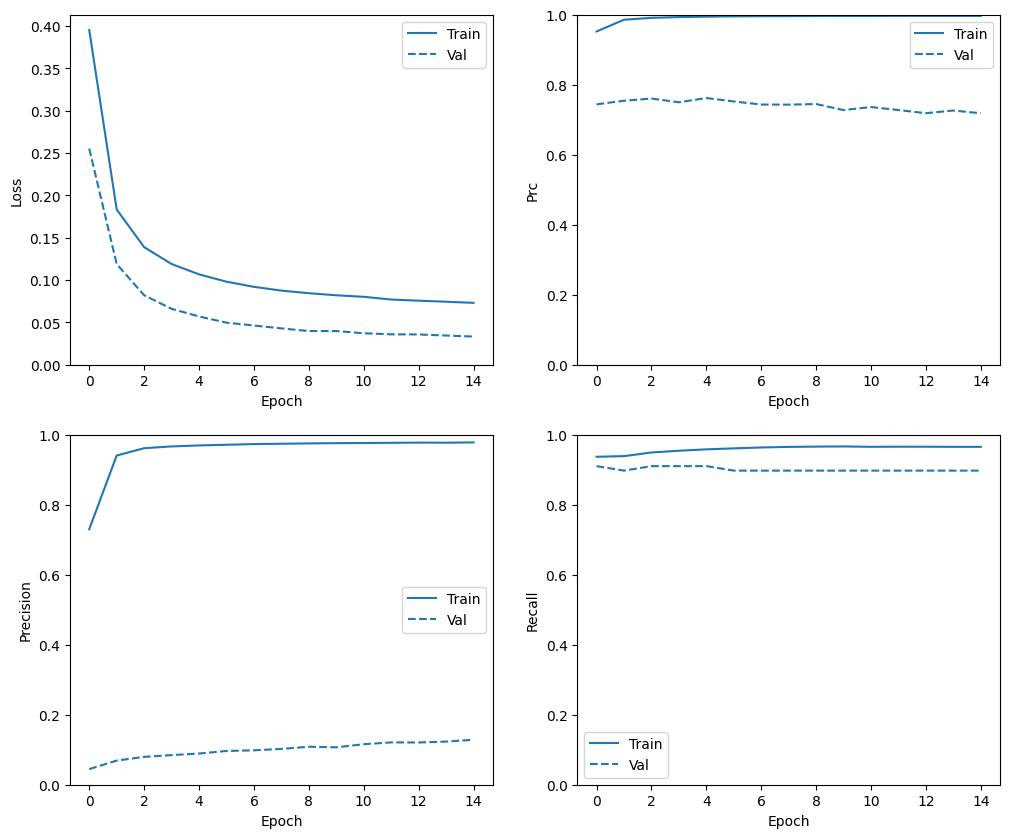

In [50]:
plot_metrics(resampled_history)

### Re-train


Because training is easier on the balanced data, the above training procedure may overfit quickly. 

So break up the epochs to give the `tf.keras.callbacks.EarlyStopping` finer control over when to stop training.

In [51]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 2s 48ms/step - loss: 0.7082 - tp: 19210.0000 - fp: 16080.0000 - tn: 49818.0000 - fn: 1421.0000 - accuracy: 0.7977 - precision: 0.5443 - recall: 0.9311 - auc: 0.9420 - prc: 0.8495 - val_loss: 1.0950 - val_tp: 77.0000 - val_fp: 37185.0000 - val_tn: 8306.0000 - val_fn: 1.0000 - val_accuracy: 0.1840 - val_precision: 0.0021 - val_recall: 0.9872 - val_auc: 0.9385 - val_prc: 0.1285
Epoch 2/1000
20/20 [==============================] - 0s 25ms/step - loss: 0.6165 - tp: 19339.0000 - fp: 14306.0000 - tn: 6312.0000 - fn: 1003.0000 - accuracy: 0.6262 - precision: 0.5748 - recall: 0.9507 - auc: 0.8784 - prc: 0.9025 - val_loss: 0.9397 - val_tp: 77.0000 - val_fp: 32360.0000 - val_tn: 13131.0000 - val_fn: 1.0000 - val_accuracy: 0.2898 - val_precision: 0.0024 - val_recall: 0.9872 - val_auc: 0.9517 - val_prc: 0.2705
Epoch 3/1000
20/20 [==============================] - 0s 25ms/step - loss: 0.5398 - tp: 19449.0000 - fp: 12293.0000 - tn: 8103.0000 - fn

Epoch 20/1000
20/20 [==============================] - 1s 26ms/step - loss: 0.1887 - tp: 19314.0000 - fp: 1251.0000 - tn: 19127.0000 - fn: 1268.0000 - accuracy: 0.9385 - precision: 0.9392 - recall: 0.9384 - auc: 0.9810 - prc: 0.9848 - val_loss: 0.1683 - val_tp: 71.0000 - val_fp: 1098.0000 - val_tn: 44393.0000 - val_fn: 7.0000 - val_accuracy: 0.9758 - val_precision: 0.0607 - val_recall: 0.9103 - val_auc: 0.9725 - val_prc: 0.7634
Epoch 21/1000
20/20 [==============================] - 0s 25ms/step - loss: 0.1808 - tp: 19232.0000 - fp: 1134.0000 - tn: 19326.0000 - fn: 1268.0000 - accuracy: 0.9414 - precision: 0.9443 - recall: 0.9381 - auc: 0.9827 - prc: 0.9860 - val_loss: 0.1600 - val_tp: 70.0000 - val_fp: 1081.0000 - val_tn: 44410.0000 - val_fn: 8.0000 - val_accuracy: 0.9761 - val_precision: 0.0608 - val_recall: 0.8974 - val_auc: 0.9729 - val_prc: 0.7634
Epoch 22/1000
20/20 [==============================] - 0s 25ms/step - loss: 0.1745 - tp: 19270.0000 - fp: 1069.0000 - tn: 19396.0000 - f

### Re-check training history

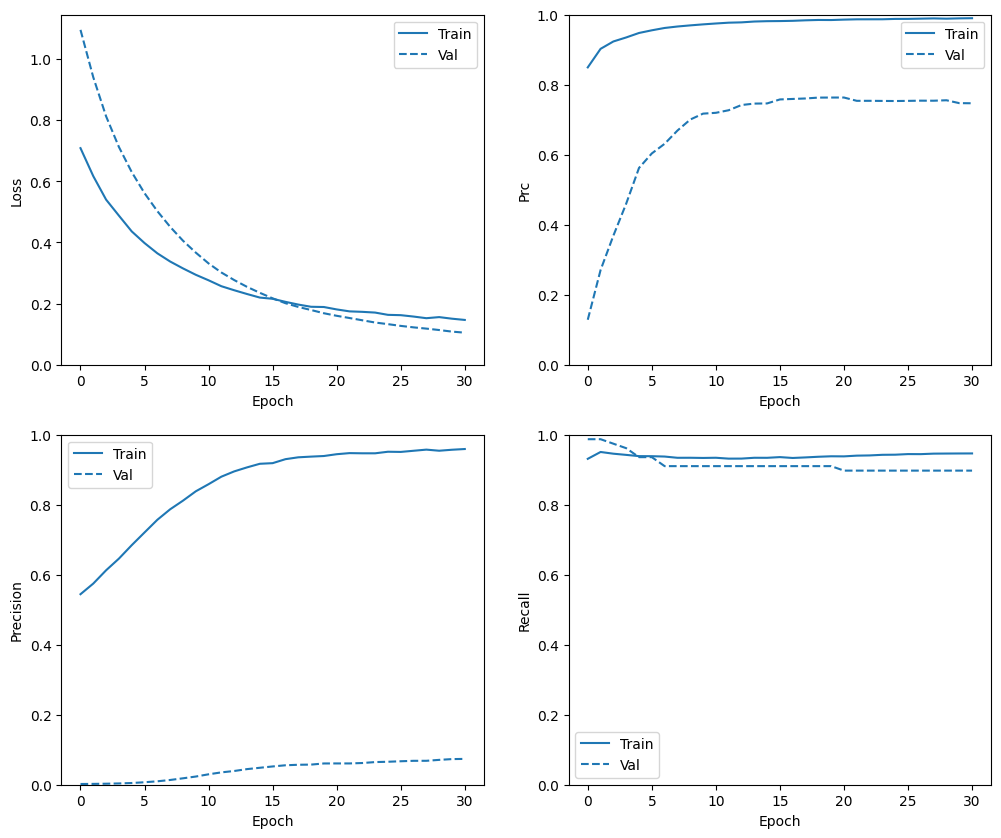

In [52]:
plot_metrics(resampled_history)

### Evaluate metrics

In [53]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 1ms/step


loss :  0.15973372757434845
tp :  84.0
fp :  1356.0
tn :  55508.0
fn :  14.0
accuracy :  0.9759488701820374
precision :  0.05833333358168602
recall :  0.8571428656578064
auc :  0.9540590047836304
prc :  0.6833170056343079

Legitimate Transactions Detected (True Negatives):  55508
Legitimate Transactions Incorrectly Detected (False Positives):  1356
Fraudulent Transactions Missed (False Negatives):  14
Fraudulent Transactions Detected (True Positives):  84
Total Fraudulent Transactions:  98


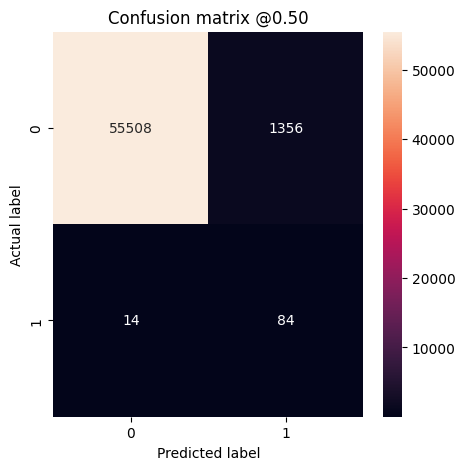

In [54]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### Plot the ROC

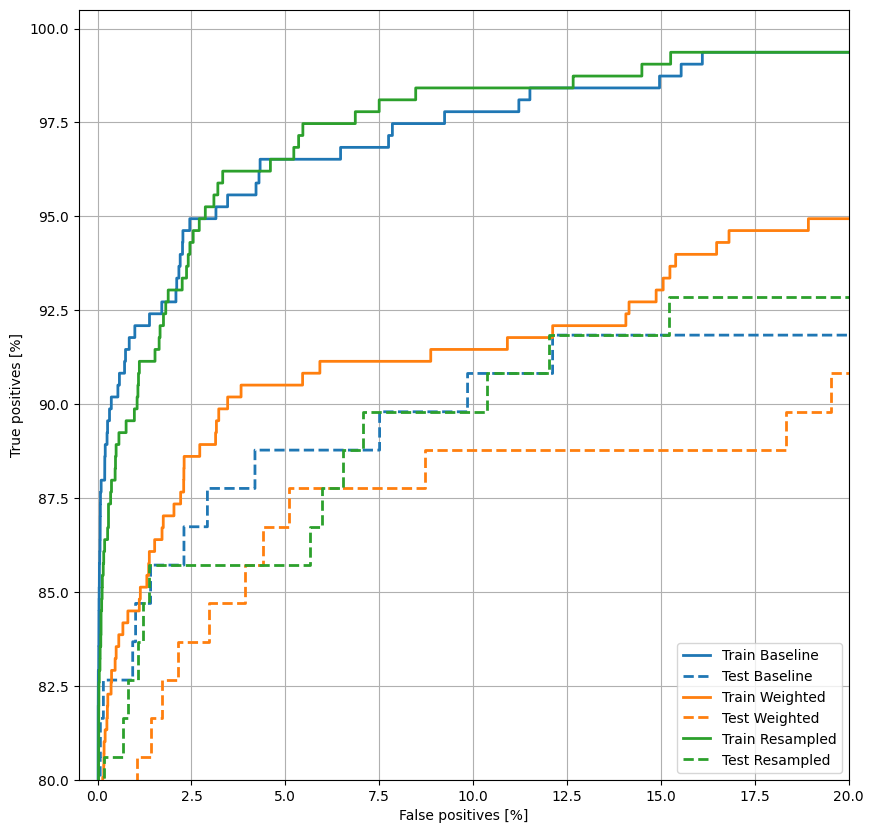

In [55]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC


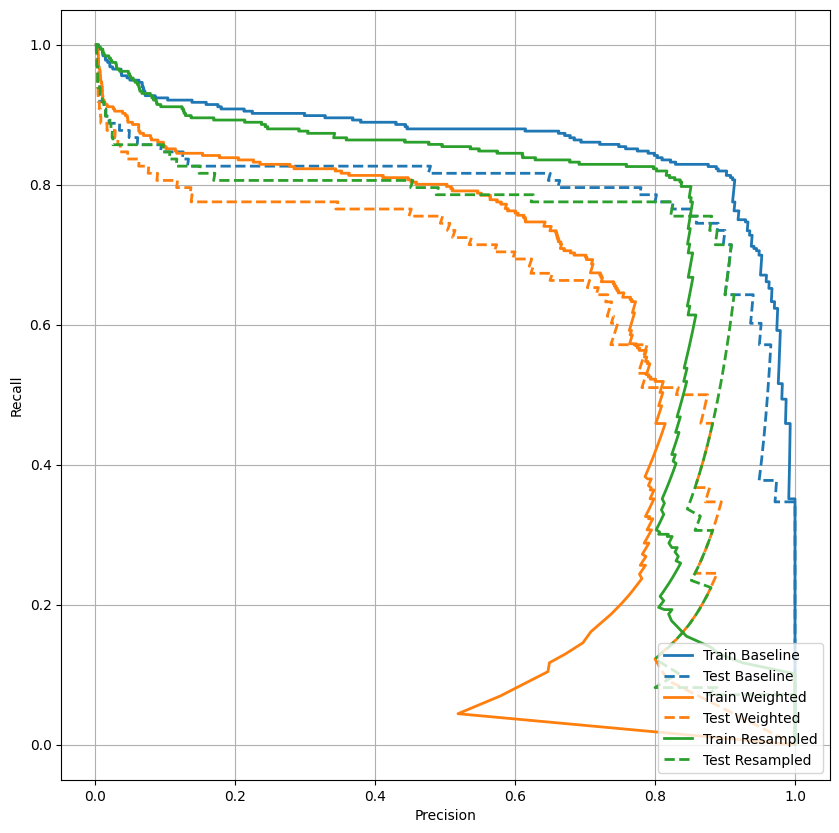

In [56]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

## Applying this tutorial to your problem

Imbalanced data classification is an inherently difficult task since there are so few samples to learn from. You should always start with the data first and do your best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point your model may struggle to improve and yield the results you want, so it is important to keep in mind the context of your problem and the trade offs between different types of errors.